### Test mapping

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os,sys
import mudata
import anndata
import scanpy as sc
import pandas as pd
import numpy as np

from typing import List, Dict, Union

In [3]:
import multi_view_atlas as mva

### Load dataset

In [4]:

datadir = '/nfs/team205/ed6/data/Fetal_immune/cellxgene_h5ad_files/scRNA_data/'
h5ad_files = [f for f in os.listdir(datadir) if f.endswith('embedding.h5ad')]

In [5]:
adata_full = sc.read_h5ad(os.path.join(datadir, 'PAN.A01.v01.raw_count.20210429.NKT.embedding.h5ad'), backed=False)

In [6]:
sc.pp.subsample(adata_full, 0.25, copy=False)

In [7]:
## Split in reference and query
query_cells = np.random.choice(adata_full.obs_names, size=int(np.round(adata_full.n_obs*0.1)), replace=False)
adata_query = adata_full[query_cells].copy()
adata_full = adata_full[~adata_full.obs_names.isin(query_cells)].copy()

In [8]:
assert adata_full.obs_names.isin(adata_query.obs_names).sum() == 0

In [9]:
### Split by organ
assign_dict = {
    'hematopoietic_tissue':['BM', "LI", "YS"],
    'lymphoid_tissue':['TH', "MLN", "SP"],
    'peripheral_tissue':['SK', "GU", 'KI']
}
annotation_col = 'organ'

assign_tab = np.vstack([np.where(adata_full.obs[annotation_col].isin(assign_dict[k]), 1, 0) for k in assign_dict.keys()]).T
assign_tab = pd.DataFrame(assign_tab, columns = assign_dict.keys(), index = adata_full.obs_names)

## Make dictionary of parent-child structure of views
view_hierarchy = { 'full':{
    'lymphoid_tissue':None,
    'hematopoietic_tissue':None,
    'peripheral_tissue':None
    }
}

In [10]:
import multi_view_atlas as mva

In [11]:
import traceback
adata_full.obsm['view_assign'] = assign_tab.copy()
adata_full.uns['view_hierarchy'] = view_hierarchy.copy()
# try:
mvatlas = mva.tl.MultiViewAtlas(adata_full, transition_rule='organ') 
# except:
#     v = traceback.format_exc()

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/mudata/_core/mudata.py:569: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col
/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/mudata/_core/mudata.py:569: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col


### Update atlas

In [12]:
### Split by age in hematopoietic tissue
transition_rule = 'age'
parent_view = 'hematopoietic_tissue'

assign_tab = np.vstack([
    np.where(mvatlas.mdata[parent_view].obs[transition_rule] < 10, 1, 0),
    np.where(mvatlas.mdata[parent_view].obs[transition_rule] >= 10, 1, 0)
    ]).T
assign_tab = pd.DataFrame(
    assign_tab, 
    columns = ['first_trimester', 'second_trimester'], 
    index = mvatlas.mdata[parent_view].obs_names)


In [13]:
mvatlas.update_views(parent_view=parent_view, child_assign_tab=assign_tab, transition_rule=transition_rule)

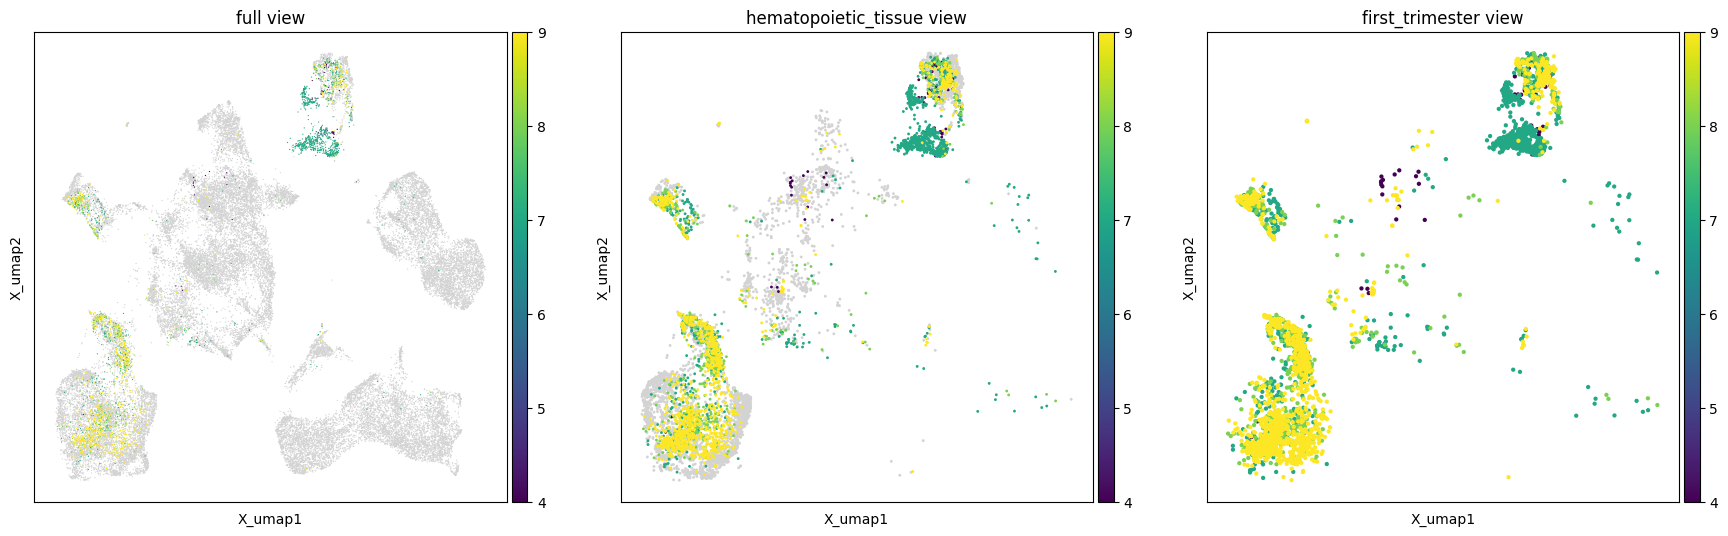

In [14]:
mva.pl.multiview_embedding(mvatlas.mdata, view='first_trimester', color='age')

### Test mapping query cells

In [35]:
from multi_view_atlas.utils import *
import multi_view_atlas as mva

In [36]:
## Map first depth level (by organ) 
if 'age' in adata_query.obs:
    age_obs = adata_query.obs['age'].copy()
    adata_query.obs.drop('age', 1, inplace=True)
mvatlas_mapped = mva.tl.add_query(mvatlas, adata_query)

Assigning to lymphoid_tissue from full
Transition rule: organ


/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    []

    Inferred to be: empty

  value_idx = self._prep_dim_index(value.index, attr)
/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    []

    Inferred to be: empty

  value_idx = self._prep_dim_index(value.index, attr)


Assigning to hematopoietic_tissue from full
Transition rule: organ


/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    []

    Inferred to be: empty

  value_idx = self._prep_dim_index(value.index, attr)
/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    []

    Inferred to be: empty

  value_idx = self._prep_dim_index(value.index, attr)


Assigning to peripheral_tissue from full
Transition rule: organ


/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    []

    Inferred to be: empty

  value_idx = self._prep_dim_index(value.index, attr)
/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    []

    Inferred to be: empty

  value_idx = self._prep_dim_index(value.index, attr)


Assigning to first_trimester from hematopoietic_tissue
Transition rule: age
Assigning to second_trimester from hematopoietic_tissue
Transition rule: age


In [37]:
mvatlas.mdata

MuData object with n_obs × n_vars = 39209 × 33538
  obs:	'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation'
  obsm:	'view_assign'
  6 modalities
    full:	39209 x 33538
      obs:	'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation', 'view_color'
      var:	'GeneID', 'GeneName', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'scvi_model_var'
      uns:	'leiden', 'scvi', 'umap', 'view_hierarchy'
      obsm:	'X_scvi', 'X_umap', 'view_assign'
      obsp:	'scvi_connectivities', 'scvi_distances'
    lymphoid_tissue:	27537 x 0
      obs:	'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation'
      obsm:	'X_scvi', 'X_umap', 'view_assign'
      obsp:	'scvi_connectivities', 'scvi_distances'
    hematopoietic_tissue:	7195 x 0
      obs:	'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation', 'view_color'
      obsm:	'X_scvi', 'X_umap', 'view_assign'
      obsp:	'scvi_connectivities', 'scvi_distances'
    peripheral_tissue:	4477 x 0
      obs:	'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation'
      obsm:	'X_scvi', 'X_umap', 'view_assign'
      obsp:	'scvi_connectivities', 'scvi_distances'
    first_trimester:	3163 x 0
      obs:	'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation'
      obsm:	'X_scvi', 'X_umap', 'view_assign'
      obsp:	'scvi_connectivities', 'scvi_distances'
    second_trimester:	4032 x 0
      obs:	'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation'
      obsm:	'X_scvi', 'X_umap', 'view_assign'
      obsp:	'scvi_connectivities', 'scvi_distances'

In [38]:
mvatlas_mapped.mdata


MuData object with n_obs × n_vars = 43565 × 33538
  obsm:	'view_assign'
  6 modalities
    full:	43565 x 33538
      obs:	'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation', 'view_color', 'dataset_group'
      var:	'GeneID', 'GeneName', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'scvi_model_var'
      uns:	'view_hierarchy'
      obsm:	'X_scvi', 'X_umap', 'view_assign'
    lymphoid_tissue:	30591 x 0
      obs:	'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation', 'dataset_group'
      obsm:	'X_scvi', 'X_umap'
    hematopoietic_tissue:	7981 x 0
      obs:	'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation', 'view_color', 'dataset_group'
      obsm:	'X_scvi', 'X_umap'
    first_trimester:	3163 x 0
      obs:	'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation'
      obsm:	'X_scvi', 'X_umap', 'view_assign'
    second_trimester:	4032 x 0
      obs:	'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation'
      obsm:	'X_scvi', 'X_umap', 'view_assign'
    peripheral_tissue:	4993 x 0
      obs:	'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation', 'dataset_group'
      obsm:	'X_scvi', 'X_umap'

In [39]:
if 'age' not in adata_query.obs:
    adata_query.obs['age'] = age_obs.astype(np.float64).copy()
mvatlas_mapped_2 = mva.tl.add_query(mvatlas_mapped, adata_query)


Assigning to first_trimester from hematopoietic_tissue
Transition rule: age
Assigning to second_trimester from hematopoietic_tissue
Transition rule: age


/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    []

    Inferred to be: empty

  value_idx = self._prep_dim_index(value.index, attr)
/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    []

    Inferred to be: empty

  value_idx = self._prep_dim_index(value.index, attr)
/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    []

    Inferred to be: empty

  value_idx = self._prep_dim_index(value.index, attr)
/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .var.index to contain strings, but got va

In [40]:
mvatlas_mapped_2.mdata

MuData object with n_obs × n_vars = 43565 × 33538
  obsm:	'view_assign'
  6 modalities
    full:	43565 x 33538
      obs:	'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation', 'view_color', 'dataset_group'
      var:	'GeneID', 'GeneName', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'scvi_model_var'
      uns:	'view_hierarchy'
      obsm:	'X_scvi', 'X_umap', 'view_assign'
    lymphoid_tissue:	30591 x 0
      obs:	'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation', 'dataset_group'
      obsm:	'X_scvi', 'X_umap'
    hematopoietic_tissue:	7981 x 0
      obs:	'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation', 'view_color', 'dataset_group'
      obsm:	'X_scvi', 'X_umap'
    first_trimester:	3515 x 0
      obs:	'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation', 'dataset_group'
      obsm:	'X_scvi', 'X_umap'
    second_trimester:	4466 x 0
      obs:	'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation', 'dataset_group'
      obsm:	'X_scvi', 'X_umap'
    peripheral_tissue:	4993 x 0
      obs:	'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation', 'dataset_group'
      obsm:	'X_scvi', 'X_umap'

In [39]:
all(atla_cells_1 == atla_cells_0)

True

In [57]:
from multi_view_atlas.tl.map_query import *

In [58]:
view_pairs = []
view_str = pd.json_normalize(mvatlas.view_hierarchy).columns.str.split(".")
for s in view_str:
    depth = 0
    while depth < (len(s) - 1):
        # view_pair = s[depth: depth + 2]
        view_pairs.append((depth, s[depth], s[depth + 1]))
        depth += 1
view_pairs = pd.DataFrame(view_pairs, columns=['depth', 'current_view', 'next_view'])
view_pairs = view_pairs.sort_values('depth')
view_pairs = view_pairs.drop_duplicates()


In [59]:
# Check if query cells already in mdata
if adata_query.obs_names.isin(mvatlas.mdata.obs_names).all():
    vdata_full = mvatlas.mdata['full'].copy()
else:
    vdata_full = concatenate_query(mvatlas, adata_query, "full")


new_view_assign = pd.DataFrame()
vdata_dict = {}
for i, row in view_pairs.iterrows():
    depth = row['depth']
    current_view = row['current_view']
    next_view = row['next_view']
    if any(adata_query.obs_names.isin(mvatlas.mdata[next_view].obs_names)):
        logging.info(f"Query cells already in {next_view}")
        v_assign = mvatlas.mdata.obsm['view_assign'][[next_view]]
        vdata_dict[next_view] = mvatlas.mdata[next_view].copy()
    else:
        print(f"Assigning to {next_view} from {current_view}")
        adata_query_concat = AnnData(obs=adata_query.obs, obsm=adata_query.obsm, obsp=adata_query.obsp)
        if depth > 0:
            adata_query_concat = adata_query_concat[new_view_assign.loc[adata_query_concat.obs_names, current_view] == 1].copy(
            )
        v_assign, next_view_adata = map_next_view(mvatlas, adata_query_concat, current_view=current_view, next_view=next_view)
        vdata_dict[next_view] = next_view_adata

    new_view_assign = pd.concat([new_view_assign, v_assign], 1)

/tmp/ipykernel_20338/2042549763.py:30: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  new_view_assign = pd.concat([new_view_assign, v_assign], 1)
/tmp/ipykernel_20338/2042549763.py:30: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  new_view_assign = pd.concat([new_view_assign, v_assign], 1)
/tmp/ipykernel_20338/2042549763.py:30: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  new_view_assign = pd.concat([new_view_assign, v_assign], 1)
/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to ge

Assigning to first_trimester from hematopoietic_tissue
Transition rule: age
Assigning to second_trimester from hematopoietic_tissue
Transition rule: age


/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    []

    Inferred to be: empty

  value_idx = self._prep_dim_index(value.index, attr)
/tmp/ipykernel_20338/2042549763.py:30: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  new_view_assign = pd.concat([new_view_assign, v_assign], 1)


In [ ]:
vdata_full

In [80]:
vdata_full.obsm['view_assign'] = new_view_assign.copy()
vdata_full.uns['view_hierarchy'] = mvatlas.view_hierarchy
vdata_dict['full'] = vdata_full
mdata = mudata.MuData(vdata_dict)
mdata.mod['full'] = mdata.mod['full'][mdata.obs_names].copy()
mvatlas = MultiViewAtlas(mdata, transition_rule='organ')

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/mudata/_core/mudata.py:569: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col
/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/mudata/_core/mudata.py:569: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col


In [82]:

mvatlas.view_transition_rule = 

MultiViewAtlas object with view hierarchy:
	full:
	  hematopoietic_tissue:
	    first_trimester: null
	    second_trimester: null
	  lymphoid_tissue: null
	  peripheral_tissue: null
	
MuData object with n_obs × n_vars = 43565 × 33538
  obsm:	'view_assign'
  6 modalities
    lymphoid_tissue:	30591 x 0
      obs:	'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation', 'dataset_group'
      obsm:	'X_scvi', 'X_umap'
    hematopoietic_tissue:	7981 x 0
      obs:	'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation', 'view_color', 'dataset_group'
      obsm:	'X_scvi', 'X_umap'
    periphe

In [ ]:
# Check if query cells already in mdata
if adata_query.obs_names.isin(mvatlas.mdata.obs_names).all():
    vdata_full = mvatlas.mdata['full'].copy()
else:
    vdata_full = concatenate_query(mvatlas, adata_query, "full")

new_view_assign = pd.DataFrame()
vdata_dict = {}
for i, row in view_pairs.iterrows():
    depth = row['depth']
    current_view = row['current_view']
    next_view = row['next_view']
    if any(adata_query.obs_names.isin(mvatlas.mdata[next_view].obs_names)):
        logging.info(f"Query cells already in {next_view}")
        v_assign = mvatlas.mdata.obsm['view_assign'][[next_view]]
        vdata_dict[next_view] = mvatlas.mdata[next_view].copy()
    else:
        print(f"Assigning to {next_view} from {current_view}")
        adata_query_concat = AnnData(obs=adata_query.obs, obsm=adata_query.obsm, obsp=adata_query.obsp)
        if depth > 0:
            adata_query_concat = adata_query_concat[new_view_assign.loc[adata_query_concat.obs_names, current_view] == 1].copy(
            )
        v_assign = map_next_view(mvatlas, adata_query_concat, current_view=current_view, next_view=next_view)
        q_cells = vdata_full.obs_names[(v_assign[next_view] == 1) & (
            vdata_full.obs['dataset_group'] == 'query')]
        adata_query_concat = adata_query_concat[adata_query_concat.obs_names.isin(q_cells)].copy()
        vdata_dict[next_view] = concatenate_query(mvatlas, adata_query_concat[q_cells], next_view)

    new_view_assign = pd.concat([new_view_assign, v_assign], 1)

new_view_assign = new_view_assign.fillna(0)
vdata_full.obsm['view_assign'] = new_view_assign.copy()
vdata_full.uns['view_hierarchy'] = mvatlas.view_hierarchy

view_transition_rule = mvatlas.view_transition_rule.copy()
trans_rule = pd.Series(mvatlas.view_transition_rule.values.ravel()).dropna().unique()[0]
mvatlas_mapped = MultiViewAtlas(vdata_full, transition_rule=trans_rule)
for v in mvatlas_mapped.views:
    if v != 'full':
        mvatlas_mapped.mdata.mod[v] = vdata_dict[v]
mvatlas_mapped.view_transition_rule = view_transition_rule.copy()


In [140]:
import numpy as np
import pandas as pd
import pytest

from multi_view_atlas.tl import MultiViewAtlas
from multi_view_atlas.tl.map_query import add_query
from multi_view_atlas.utils import (
    get_parent_view,
    get_views_from_structure,
    sample_dataset,
)


# def test_consecutive_mapping():
    # '''Test that consecutive mapping is the same as mapping in one step'''
adata = sample_dataset()
# split in query and atlas
query_cells = np.random.choice(adata.obs_names, size=int(np.round(adata.n_obs*0.1)), replace=False)
adata_query = adata[query_cells].copy()
adata = adata[~adata.obs_names.isin(query_cells)].copy()
mva = MultiViewAtlas(adata)    

## New embedding for NKT view
v = 'NKT cells'
vadata = mva[v]
# sc.pp.pca(vadata)
vadata.obsm[f'X_pca_{v}'] = vadata.obsm['X_pca'].copy()
mva.mdata[v].obsm = vadata.obsm.copy()

## Change transition rule to use NKT specific PCA
mva.set_transition_rule('NKT cells', 'T cells', 'X_pca_NKT cells')
mva.view_transition_rule

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/mudata/_core/mudata.py:569: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col
/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/mudata/_core/mudata.py:569: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col


,full,myeloid,lymphoid,NKT cells,T cells,B cells
full,NaN,X_pca,X_pca,X_pca,X_pca,X_pca
myeloid,X_pca,NaN,NaN,NaN,NaN,NaN
lymphoid,X_pca,NaN,NaN,X_pca,X_pca,X_pca
NKT cells,X_pca,NaN,X_pca,NaN,X_pca_NKT cells,NaN
T cells,X_pca,NaN,X_pca,X_pca_NKT cells,NaN,NaN
B cells,X_pca,NaN,X_pca,NaN,NaN,NaN


In [141]:
adata_query_1 = adata_query.copy()
adata_query_1.obsm['X_pca_NKT cells'] = adata_query.obsm['X_pca'].copy()
adata_query_2 = adata_query.copy()
mva_1 = add_query(mva, adata_query_1)
mva_2 = add_query(mva, adata_query_2)
assert mva_1.mdata.obsm['view_assign']['T cells'].sum() > mva_2.mdata.obsm['view_assign']['T cells'].sum()

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


Assigning to myeloid from full
Transition rule: X_pca


/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    []

    Inferred to be: empty

  value_idx = self._prep_dim_index(value.index, attr)
/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    []

    Inferred to be: empty

  value_idx = self._prep_dim_index(value.index, attr)
/nfs/team205/ed6/bin/mul

Assigning to lymphoid from full
Transition rule: X_pca


/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    []

    Inferred to be: empty

  value_idx = self._prep_dim_index(value.index, attr)
/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    []

    Inferred to be: empty

  value_idx = self._prep_dim_index(value.index, attr)
/nfs/team205/ed6/bin/mul

Assigning to NKT cells from lymphoid
Transition rule: X_pca


KeyError: "Values ['AAATGTTGTGGCAT-1', 'AACGCAACAAGTAG-1', 'AACGCATGACCCAA-1', 'AACGCATGCCTTCG-1', 'AACGCCCTCGGGAA-1', 'AACTCTTGCAGGAG-1', 'AAGAACGAGTGTTG-1', 'AAGAAGACGTAGGG-1', 'AATCTCTGCTTTAC-1', 'AATGATACACCAAC-1', 'ACAAATTGCTCAGA-1', 'ACAGTCGACCCAAA-1', 'ACCCTCGACCTATT-1', 'ACGCAATGGTTCAG-1', 'ACTAAAACTCGACA-1', 'ACTATCACTGCCAA-1', 'ACTCAGGATTCGTT-1', 'ACTCGCACTACGAC-1', 'ACTGGCCTTCAGTG-1', 'ACTTGGGATTGACG-1', 'AGAACAGAAATGCC-1', 'AGCGATTGAGATCC-1', 'AGGGTGGACTCAAG-1', 'AGGTCATGAGTGTC-1', 'AGTCTACTAGGGTG-1', 'AGTCTACTTGCATG-1', 'AGTCTTACACCACA-1', 'ATAGCGTGCCCTTG-1', 'ATAGGCTGTCAGAC-1', 'ATATGCCTGGACAG-1', 'ATCTACACCGGGAA-1', 'ATGAGAGAAAGTGA-1', 'ATGAGAGAAGTAGA-1', 'ATTACCTGGAGGAC-1', 'ATTATGGAATCTCT-1', 'ATTCAAGACCTTTA-1', 'CAAGTCGAAACAGA-1', 'CAATTCACCCAACA-1', 'CAATTCACGATAGA-1', 'CACAGCCTTGCCAA-1', 'CACCACTGGCGAAG-1', 'CAGACCCTAAGGTA-1', 'CAGCAATGTCTACT-1', 'CAGGTAACAGACTC-1', 'CAGTGATGTACGCA-1', 'CAGTTGGACATACG-1', 'CAGTTTACCCCAAA-1', 'CATAGTCTAATCGC-1', 'CATCGGCTATGCTG-1', 'CATTGGGACTCGAA-1', 'CATTTGACCACACA-1', 'CCAAAGTGTGAGAA-1', 'CCAAGTGATCAAGC-1', 'CCGACTACCGTGTA-1', 'CCGTACACGTCATG-1', 'CCTAAGGACTAGCA-1', 'CCTCTACTGGCATT-1', 'CCTTAATGCCCAAA-1', 'CGATAGACGTAGGG-1', 'CGCTAAGACCCTTG-1', 'CGTGTAGAGTTCAG-1', 'CTAGGTGATGGTTG-1', 'CTATACTGCGCTAA-1', 'CTCATTGACCTTAT-1', 'CTCCTACTGCCTTC-1', 'CTCGAGCTCTGGAT-1', 'CTCTAAACGGCGAA-1', 'CTGAAGTGAAGCCT-1', 'CTGACAGAATCGTG-1', 'CTGAGAACCGGGAA-1', 'CTGCAGCTAACCGT-1', 'CTGCAGCTGGATTC-1', 'CTGTGAGACGAACT-1', 'CTTATCGACTCATT-1', 'CTTCATGAAGTACC-1', 'CTTTCAGAGAAACA-1', 'GAAAGATGTAAGGA-1', 'GAAATACTACCAAC-1', 'GAAGGGTGAAAGTG-1', 'GAAGGTCTGAAAGT-1', 'GAAGTAGATCCAAG-1', 'GAATTAACTGAAGA-1', 'GAGATGCTGAATGA-1', 'GAGGCAGACTTGCC-1', 'GAGTTGTGCATGGT-1', 'GAGTTGTGCTGAGT-1', 'GATAGAGAAGGGTG-1', 'GATAGCACTTGTCT-1', 'GATTTAGATTCGTT-1', 'GCAATCGAGACGTT-1', 'GCACTAGACCTTTA-1', 'GCAGGGCTAAGAAC-1', 'GCAGTCCTAACTGC-1', 'GCTCAAGAAGTCAC-1', 'GGACAGGATCTCGC-1', 'GGGACCACACGTTG-1', 'GGGACCACTGCATG-1', 'GGTAGTACCCTGTC-1', 'GTAATAACGTTGTG-1', 'GTACCCTGTCCTTA-1', 'GTAGCAACAGTCGT-1', 'GTCAACGAGTGTAC-1', 'GTCGAATGAAGGCG-1', 'GTCTAACTGGTCTA-1', 'GTGATTCTCATTTC-1', 'GTTGGATGTTTACC-1', 'TAAACAACCAACCA-1', 'TACGATCTCACTGA-1', 'TAGGAGCTAAGGCG-1', 'TAGGCATGGCGAGA-1', 'TAGGTCGACACTGA-1', 'TAGGTTCTTCTTAC-1', 'TATCGTACAGATGA-1', 'TATGGGTGCTAGCA-1', 'TATTTCCTGGTGTT-1', 'TCACCCGAGACGGA-1', 'TCAGTTACTAGAAG-1', 'TCCACTCTACACTG-1', 'TCCTATGAAAAGCA-1', 'TCGATTTGCAGCTA-1', 'TCGATTTGTCGTGA-1', 'TCTAACACCAGTTG-1', 'TCTATGTGAGTCTG-1', 'TCTCAAACCTAAGC-1', 'TGACTTACACACCA-1', 'TGATAAACGAATCC-1', 'TGATATGAACCTTT-1', 'TGATTCACTGTCAG-1', 'TGCAAGTGGGTAGG-1', 'TGCCGACTCTCCCA-1', 'TGGACCCTCATGGT-1', 'TGGCAATGCTTGTT-1', 'TGGTATCTAAACAG-1', 'TGGTTACTGACGTT-1', 'TGTAGGTGCTATGG-1', 'TTACACACTCCTAT-1', 'TTATTCCTATGCTG-1', 'TTCAAGCTTGATGC-1', 'TTCACAACCCGTTC-1', 'TTCCTAGAAAGTGA-1', 'TTGGTACTGAATCC-1', 'TTGTACACTTGCAG-1', 'TTTCAGTGTGCAGT-1', 'TCCGAAGACAATCG-1', 'CCTCTACTCTTCGC-1', 'TGCGCACTCTTGAG-1', 'TCCCGAACTTCGCC-1'], from ['AAATGTTGTGGCAT-1', 'AACGCAACAAGTAG-1', 'AACGCATGACCCAA-1', 'AACGCATGCCTTCG-1', 'AACGCCCTCGGGAA-1', 'AACTCTTGCAGGAG-1', 'AAGAACGAGTGTTG-1', 'AAGAAGACGTAGGG-1', 'AATCTCTGCTTTAC-1', 'AATGATACACCAAC-1', 'ACAAATTGCTCAGA-1', 'ACAGTCGACCCAAA-1', 'ACCCTCGACCTATT-1', 'ACGCAATGGTTCAG-1', 'ACTAAAACTCGACA-1', 'ACTATCACTGCCAA-1', 'ACTCAGGATTCGTT-1', 'ACTCGCACTACGAC-1', 'ACTGGCCTTCAGTG-1', 'ACTTGGGATTGACG-1', 'AGAACAGAAATGCC-1', 'AGCGATTGAGATCC-1', 'AGGGTGGACTCAAG-1', 'AGGTCATGAGTGTC-1', 'AGTCTACTAGGGTG-1', 'AGTCTACTTGCATG-1', 'AGTCTTACACCACA-1', 'ATAGCGTGCCCTTG-1', 'ATAGGCTGTCAGAC-1', 'ATATGCCTGGACAG-1', 'ATCTACACCGGGAA-1', 'ATGAGAGAAAGTGA-1', 'ATGAGAGAAGTAGA-1', 'ATTACCTGGAGGAC-1', 'ATTATGGAATCTCT-1', 'ATTCAAGACCTTTA-1', 'CAAGTCGAAACAGA-1', 'CAATTCACCCAACA-1', 'CAATTCACGATAGA-1', 'CACAGCCTTGCCAA-1', 'CACCACTGGCGAAG-1', 'CAGACCCTAAGGTA-1', 'CAGCAATGTCTACT-1', 'CAGGTAACAGACTC-1', 'CAGTGATGTACGCA-1', 'CAGTTGGACATACG-1', 'CAGTTTACCCCAAA-1', 'CATAGTCTAATCGC-1', 'CATCGGCTATGCTG-1', 'CATTGGGACTCGAA-1', 'CATTTGACCACACA-1', 'CCAAAGTGTGAGAA-1', 'CCAAGTGATCAAGC-1', 'CCGACTACCGTGTA-1', 'CCGTACACGTCATG-1', 'CCTAAGGACTAGCA-1', 'CCTCTACTGGCATT-1', 'CCTTAATGCCCAAA-1', 'CGATAGACGTAGGG-1', 'CGCTAAGACCCTTG-1', 'CGTGTAGAGTTCAG-1', 'CTAGGTGATGGTTG-1', 'CTATACTGCGCTAA-1', 'CTCATTGACCTTAT-1', 'CTCCTACTGCCTTC-1', 'CTCGAGCTCTGGAT-1', 'CTCTAAACGGCGAA-1', 'CTGAAGTGAAGCCT-1', 'CTGACAGAATCGTG-1', 'CTGAGAACCGGGAA-1', 'CTGCAGCTAACCGT-1', 'CTGCAGCTGGATTC-1', 'CTGTGAGACGAACT-1', 'CTTATCGACTCATT-1', 'CTTCATGAAGTACC-1', 'CTTTCAGAGAAACA-1', 'GAAAGATGTAAGGA-1', 'GAAATACTACCAAC-1', 'GAAGGGTGAAAGTG-1', 'GAAGGTCTGAAAGT-1', 'GAAGTAGATCCAAG-1', 'GAATTAACTGAAGA-1', 'GAGATGCTGAATGA-1', 'GAGGCAGACTTGCC-1', 'GAGTTGTGCATGGT-1', 'GAGTTGTGCTGAGT-1', 'GATAGAGAAGGGTG-1', 'GATAGCACTTGTCT-1', 'GATTTAGATTCGTT-1', 'GCAATCGAGACGTT-1', 'GCACTAGACCTTTA-1', 'GCAGGGCTAAGAAC-1', 'GCAGTCCTAACTGC-1', 'GCTCAAGAAGTCAC-1', 'GGACAGGATCTCGC-1', 'GGGACCACACGTTG-1', 'GGGACCACTGCATG-1', 'GGTAGTACCCTGTC-1', 'GTAATAACGTTGTG-1', 'GTACCCTGTCCTTA-1', 'GTAGCAACAGTCGT-1', 'GTCAACGAGTGTAC-1', 'GTCGAATGAAGGCG-1', 'GTCTAACTGGTCTA-1', 'GTGATTCTCATTTC-1', 'GTTGGATGTTTACC-1', 'TAAACAACCAACCA-1', 'TACGATCTCACTGA-1', 'TAGGAGCTAAGGCG-1', 'TAGGCATGGCGAGA-1', 'TAGGTCGACACTGA-1', 'TAGGTTCTTCTTAC-1', 'TATCGTACAGATGA-1', 'TATGGGTGCTAGCA-1', 'TATTTCCTGGTGTT-1', 'TCACCCGAGACGGA-1', 'TCAGTTACTAGAAG-1', 'TCCACTCTACACTG-1', 'TCCTATGAAAAGCA-1', 'TCGATTTGCAGCTA-1', 'TCGATTTGTCGTGA-1', 'TCTAACACCAGTTG-1', 'TCTATGTGAGTCTG-1', 'TCTCAAACCTAAGC-1', 'TGACTTACACACCA-1', 'TGATAAACGAATCC-1', 'TGATATGAACCTTT-1', 'TGATTCACTGTCAG-1', 'TGCAAGTGGGTAGG-1', 'TGCCGACTCTCCCA-1', 'TGGACCCTCATGGT-1', 'TGGCAATGCTTGTT-1', 'TGGTATCTAAACAG-1', 'TGGTTACTGACGTT-1', 'TGTAGGTGCTATGG-1', 'TTACACACTCCTAT-1', 'TTATTCCTATGCTG-1', 'TTCAAGCTTGATGC-1', 'TTCACAACCCGTTC-1', 'TTCCTAGAAAGTGA-1', 'TTGGTACTGAATCC-1', 'TTGTACACTTGCAG-1', 'TTTCAGTGTGCAGT-1', 'TAGGCAACCGTCTC-1', 'CATTGTACAGCGTT-1', 'CGGACCGATGCGTA-1', 'GGAACTTGGGTAGG-1', 'TCCGAAGACAATCG-1', 'CCTCTACTCTTCGC-1', 'TGCGCACTCTTGAG-1', 'ACTAGGTGGAACCT-1', 'TCCCGAACTTCGCC-1', 'GGAGCGCTCCGAAT-1', 'AATACTGAATTGGC-1'], are not valid obs/ var names or indices."

In [133]:
mva_1

MultiViewAtlas object with view hierarchy:
	full:
	  lymphoid:
	    B cells: null
	    NKT cells:
	      T cells: null
	  myeloid: null
	
MuData object with n_obs × n_vars = 2638 × 1838
  obs:	'n_genes', 'percent_mito', 'n_counts', 'louvain', 'dataset_group'
  obsm:	'view_assign'
  6 modalities
    full:	2638 x 1838
      obs:	'n_genes', 'percent_mito', 'n_counts', 'louvain', 'dataset_group'
      var:	'n_cells'
      uns:	'view_hierarchy'
      obsm:	'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr', 'view_assign'
    myeloid:	682 x 0
      obs:	'n_genes', 'percent_mito', 'n_counts', 'louvain', 'dataset_group'
      obsm:	'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr', 'view_assign'
    lymphoid:	1956 x 0
      obs:	'n_genes', 'percent_mito', 'n_counts', 'louvain', 'dataset_group'
      obsm:	'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr', 'view_assign'
    NKT cells:	1614 x 0
      obs:	'n_genes', 'percent_mito', 'n_counts', 'louvain', 'dataset_group'
      obsm:	'X_pca', 'X_tsne', 'X_u

In [137]:
adata_query_2.obsm['X_pca_NKT cells'] = adata_query_2.obsm['X_pca'].copy()
mva_2 = add_query(mva_2, adata_query_2)

/nfs/team205/ed6/bin/multi-view-atlas/src/multi_view_atlas/tl/map_query.py:67: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  new_view_assign = pd.concat([new_view_assign, v_assign], 1)
/nfs/team205/ed6/bin/multi-view-atlas/src/multi_view_atlas/tl/map_query.py:67: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  new_view_assign = pd.concat([new_view_assign, v_assign], 1)
/nfs/team205/ed6/bin/multi-view-atlas/src/multi_view_atlas/tl/map_query.py:67: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  new_view_assign = pd.concat([new_view_assign, v_assign], 1)
/nfs/team205/ed6/bin/multi-view-atlas/src/multi_view_atlas/tl/map_query.py:67: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  new_view

In [136]:
mva_1

MultiViewAtlas object with view hierarchy:
	full:
	  lymphoid:
	    B cells: null
	    NKT cells:
	      T cells: null
	  myeloid: null
	
MuData object with n_obs × n_vars = 2638 × 1838
  obs:	'n_genes', 'percent_mito', 'n_counts', 'louvain', 'dataset_group'
  obsm:	'view_assign'
  6 modalities
    full:	2638 x 1838
      obs:	'n_genes', 'percent_mito', 'n_counts', 'louvain', 'dataset_group'
      var:	'n_cells'
      uns:	'view_hierarchy'
      obsm:	'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr', 'view_assign'
    myeloid:	682 x 0
      obs:	'n_genes', 'percent_mito', 'n_counts', 'louvain', 'dataset_group'
      obsm:	'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr', 'view_assign'
    lymphoid:	1956 x 0
      obs:	'n_genes', 'percent_mito', 'n_counts', 'louvain', 'dataset_group'
      obsm:	'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr', 'view_assign'
    NKT cells:	1614 x 0
      obs:	'n_genes', 'percent_mito', 'n_counts', 'louvain', 'dataset_group'
      obsm:	'X_pca', 'X_tsne', 'X_u

In [258]:
v_assign.shape

(44351, 1)

In [197]:
from multi_view_atlas.tl.map_query import *

# Define all current view - next view pairs for assignment
view_pairs = []
view_str = pd.json_normalize(mvatlas.view_hierarchy).columns.str.split(".")
for s in view_str:
    depth = 0
    while depth < (len(s) - 1):
        # view_pair = s[depth: depth + 2]
        view_pairs.append((depth, s[depth], s[depth+1]))
        depth += 1
view_pairs = pd.DataFrame(view_pairs, columns=['depth', 'current_view', 'next_view'])
view_pairs = view_pairs.sort_values('depth')
view_pairs = view_pairs.drop_duplicates()
new_view_assign = pd.DataFrame()
# max_depth = view_pairs['depth'].max() + 1
# Add full concat to vdata_dict
vdata_full = concatenate_query(mvatlas, adata_query, "full")
for i, row in view_pairs.iterrows():
    depth = row['depth']
    current_view = row['current_view']
    next_view = row['next_view']
    print("Depth: ", depth)
    
    print(f"Assigning to {next_view} from {current_view}")
    adata_query_concat = AnnData(obs=adata_query.obs, obsm=adata_query.obsm, obsp=adata_query.obsp)
    if depth > 0:
        adata_query_concat = adata_query_concat[new_view_assign.loc[adata_query_concat.obs_names, current_view] == 1].copy()
    v_assign = map_next_view(mvatlas, adata_query_concat, current_view=current_view, next_view=next_view)
    if v_assign is not None:
        new_view_assign = pd.concat([new_view_assign, v_assign], 1)

new_view_assign = new_view_assign.fillna(0)

index
FCAImmP7352194-TAAGTGCCAATGGACG    1
FCAImmP7504912-CTTGGCTGTGTGCCTG    1
FCAImmP7316889-CAGCAGCCACATTAGC    1
FCAImmP7316891-GGGAGATCAGCGTCCA    1
FCAImmP7316901-AGCGTATCAGAGTGTG    1
                                  ..
FCAImmP7462244-AGCGGTCAGGCTAGAC    1
FCAImmP7316890-AACTCAGAGCAGATCG    1
FCAImmP7198628-CTGAAGTGTTCCACAA    1
FCAImmP7862084-TGCTACCCAACAACCT    1
FCAImmP7862084-GGGCACTCAAGGACTG    1
Name: hematopoietic_tissue, Length: 3515, dtype: int64

In [151]:
vdata_full[np.where(v_assign_dict['lymphoid_tissue'] == 1)[0]].obs[['organ']].value_counts()

organ
TH       22867
SP        6541
MLN       1183
dtype: int64

In [ ]:

new_view_assign = pd.concat(v_assign_dict.values(), axis=1)
vdata_full.obsm['view_assign'] = new_view_assign.copy()
vdata_full.uns['view_hierarchy'] = mvatlas.view_hierarchy

In [90]:
mvatlas.view_hierarchy

{'full': {'lymphoid_tissue': None,
  'hematopoietic_tissue': {'first_trimester': None, 'second_trimester': None},
  'peripheral_tissue': None}}

In [129]:
from sklearn.neighbors import KNeighborsClassifier
from anndata import AnnData
from pandas.api.types import is_numeric_dtype
import logging

# Define all current view - next view pairs for assignment
view_pairs = []
view_str = pd.json_normalize(mvatlas.view_hierarchy).columns.str.split('.')
for s in view_str:
    i = 0
    while i < (len(s)-1):
        view_pairs.append(s[i:i+2])
        i += 1 

vdata_dict = {}
v_assign_dict = {}

## Add full concat to vdata_dict
vdata_dict['full'] = _concatenate_query(mvatlas, adata_query, 'full')
for i,p in enumerate(view_pairs):
    print(f'Assigning to {p[1]} from {p[0]}')
    adata_query_concat = AnnData(obs=adata_query.obs, obsm=adata_query.obsm, obsp=adata_query.obsp)
    next_view_adata, v_assign = assign_to_next_view(mvatlas, adata_query_concat, current_view=p[0], next_view=p[1])
    if next_view_adata is not None:
        vdata_dict[p[1]], v_assign_dict[p[1]] = next_view_adata, v_assign

new_view_assign = pd.concat(v_assign_dict.values(), axis=1)
mvatlas.mdata.obsm['view_assign'] = new_view_assign

for k in vdata_dict.keys():
    mvatlas.mdata.mod[k] = vdata_dict[k]

mvatlas.mdata.obs = mvatlas.mdata['full'].obs.copy()
mvatlas.obs = mvatlas.mdata['full'].obs.copy()
mvatlas.mdata.obsm['view_assign'] = new_view_assign.copy()

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


Assigning to lymphoid_tissue from full
Transition rule: organ


/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    []

    Inferred to be: empty

  value_idx = self._prep_dim_index(value.index, attr)
/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    []

    Inferred to be: empty

  value_idx = self._prep_dim_index(value.index, attr)


Assigning to hematopoietic_tissue from full
Transition rule: organ


/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    []

    Inferred to be: empty

  value_idx = self._prep_dim_index(value.index, attr)
/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    []

    Inferred to be: empty

  value_idx = self._prep_dim_index(value.index, attr)
/home/jovyan/my-conda-en

Assigning to first_trimester from hematopoietic_tissue
Transition rule: age
Assigning to hematopoietic_tissue from full
Transition rule: organ


/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    []

    Inferred to be: empty

  value_idx = self._prep_dim_index(value.index, attr)
/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    []

    Inferred to be: empty

  value_idx = self._prep_dim_index(value.index, attr)
/home/jovyan/my-conda-en

Assigning to second_trimester from hematopoietic_tissue
Transition rule: age
Assigning to peripheral_tissue from full
Transition rule: organ


/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    []

    Inferred to be: empty

  value_idx = self._prep_dim_index(value.index, attr)
/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    []

    Inferred to be: empty

  value_idx = self._prep_dim_index(value.index, attr)


In [146]:
mvatlas.mdata

MuData object with n_obs × n_vars = 43565 × 33538
  obs:	'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation', 'view_color', 'dataset_group'
  obsm:	'view_assign'
  6 modalities
    full:	43565 x 33538
      obs:	'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation', 'view_color', 'dataset_group'
      var:	'GeneID', 'GeneName', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'scvi_model_var'
      obsm:	'X_scvi', 'X_umap'
    lymphoid_tissue:	30591 x 0
      obs:	'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation', 'dataset_group'
      obsm:	'X_scvi', 'X_umap'
    hematopoietic_tissue:	7981 x 0
      obs:	'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation', 'view_color', 'dataset_group'
      obsm:	'X_scvi', 'X_umap'
    peripheral_tissue:	4993 x 0
      obs:	'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation', 'dataset_group'
      obsm:	'X_scvi', 'X_umap'
    first_trimester:	3604 x 0
      obs:	'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation', 'dataset_group'
      obsm:	'X_scvi', 'X_umap'
    second_trimester:	7947 x 0
      obs:	'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation', 'dataset_group'
      obsm:	'X_scvi', 'X_umap'

In [58]:
atlas_obs = concat_adata.obs_names[concat_adata.obs[batch_key] == batch_categories[0]]
v_assign = mvatlas.mdata.obsm['view_assign'][[next_view]]
v_assign_query = assign_from_similarity(concat_adata, X_similarity, v_assign)

ValueError: Lengths must match to compare

In [ ]:

# Get assignment to next view
v_assign = mvatlas.mdata.obsm['view_assign'][[next_view]]
v_assign_query = assign_from_similarity(concat_adata, X_similarity, v_assign)
v_assign = pd.concat([v_assign, v_assign_query], axis=0)

In [27]:
# Concatenate query to atlas in current view
current_view = 'full'
concat_adata = _concatenate_query(mvatlas, adata_query, current_view)

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [43]:


    # if transition_rule is not None:
    #     assign_tab = mvatlas._assign_tab_from_transition_rule(concat_adata, transition_rule, next_view)
    #     concat_adata = mvatlas._split_to_next_view(concat_adata, next_view, assign_tab)


/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [50]:
mapped_view_assign = pd.DataFrame()
        

[['full', 'lymphoid_tissue'],
 ['full', 'hematopoietic_tissue'],
 ['hematopoietic_tissue', 'first_trimester'],
 ['full', 'hematopoietic_tissue'],
 ['hematopoietic_tissue', 'second_trimester'],
 ['full', 'peripheral_tissue']]

In [52]:
# Define all current view - next view pairs to test
all_view_pairs = []
for current_view in mvatlas.view_hierarchy.keys():
    next_views = mvatlas.view_hierarchy[current_view].keys()
    for next_view in next_views:
        all_view_pairs.append((current_view, next_view))

'peripheral_tissue'

In [46]:
adata_query.obsm['view_assign'] = mapped_view_assign.copy()
adata_query.uns['view_hierarchy'] = view_hierarchy.copy()
# try:
mv_query = mva.tl.MultiViewAtlas(adata_query, transition_rule='organ') 

KeyError: 'first_trimester'

In [32]:
v_assign = mvatlas.mdata.obsm['view_assign'][[next_view]]
v_assign_query = assign_from_similarity(concat_adata, X_similarity, v_assign)
v_assign = pd.concat([v_assign, v_assign_query], axis=0)

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


,peripheral_tissue
index,
FCAImmP7579224-ATTATCCAGAGAACAG,1
FCAImmP7579224-GACGGCTAGCCACCTG,1
FCAImmP7579224-GCGGGTTGTCCGAGTC,1
FCAImmP7579224-AGTTGGTAGTGTTAGA,1
FCAImmP7579224-CGATCGGTCCCAAGTA,1
...,...
Human_colon_16S8159186-CTCTAATCAATAGCAA,0
FCAImmP7579216-CTGAAACGTTGCCTCT,0
FCAImmP7579230-TGCGTGGCATTACCTT,0


In [109]:

batch_key = 'dataset_group'
transition_rule = 'organ'
batch_categories = ['atlas', 'query']
next_view = 'lymphoid_tissue'




In [112]:
view_assign[next_view]

index
FCAImmP7579224-ATTATCCAGAGAACAG    0
FCAImmP7579224-GACGGCTAGCCACCTG    0
FCAImmP7579224-GCGGGTTGTCCGAGTC    0
FCAImmP7579224-AGTTGGTAGTGTTAGA    0
FCAImmP7579224-CGATCGGTCCCAAGTA    0
                                  ..
FCAImmP7277565-AGTAGTCCATGTAAGA    1
FCAImmP7277565-GTCAAGTCATAAAGGT    1
FCAImmP7277565-ATCATGGGTAAATGTG    1
FCAImmP7277565-ATTGGTGCACGCTTTC    1
FCAImmP7277565-GGCTCGACAGGATTGG    1
Name: lymphoid_tissue, Length: 156835, dtype: int64

In [106]:
if isinstance(transition_rule, str):
    if transition_rule in adata_query.obs.columns:
        adata_query.obs[transition_rule]

In [32]:
# def obs_transition_rule_to_assign_dict(adata_full, transition_rule):
assign_dict = {}
for 

# adata_full.obs[transition_rule].unique()


['SK', 'GU', 'KI']
Categories (3, object): ['GU', 'KI', 'SK']